<h1><b>Задача по предсказанию рейтинга шоколада

<h3><b>Никнейм на Kaggle: 

# Описание задачи

In [1]:
# Даны характеристики шоколадок и по ним нужно предсказать их рейтинг.

# Описание данных
# Company - компания производитель
# Specific Bean Origin - географический регион происхождения
# REF - параметр, определяющий момент внесения записи в базу данных (чем выше значение, тем "свежее" запись)
# Review - дата публикации отзыва
# Cocoa Percent - процентное содержание какао
# Company Location - страна производитель
# Rating - экспертный рейтинг
# Bean Type - используемый сорт какао-бобов, если таковой имеется
# Broad Bean Origin - географический регион происхождения какао-бобов

# Файлы с данными
# choco_train.csv - тренировочные данные
# choco_test_new.csv - тестовые данные
# choco_sample_submission.csv - пример submission

# Импорт библиотек, константы

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from category_encoders.ordinal import OrdinalEncoder
from category_encoders.one_hot import OneHotEncoder
from category_encoders.target_encoder import TargetEncoder
from category_encoders.leave_one_out import LeaveOneOutEncoder
from sklearn.preprocessing import LabelEncoder

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRanker, LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
import optuna

In [6]:
import association_metrics as am
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_absolute_percentage_error as MAPE, mean_absolute_error as MAE, r2_score, mean_squared_error as MSE
from scipy import stats

from sklearn.pipeline import Pipeline

In [7]:
RANDOM_STATE = 42

# Загрузка данных

In [8]:
TRAIN = "https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/chocolate_train.csv"
TEST = "https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/chocolate_test_new.csv"
# TRAIN = 'data\chocolate-rating\chocolate_train.csv'
# TEST = 'data\chocolate-rating\chocolate_test_new.csv'

In [9]:
train_df = pd.read_csv(TRAIN)

In [10]:
test_df = pd.read_csv(TEST)

# Обзор данных

In [11]:
train_df.head()

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
0,Willie's Cacao,Rio Caribe,457,2009,72%,U.K.,3.25,Trinitario,Venezuela
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",508,2010,72%,Switzerland,3.50,,Venezuela
2,Dark Forest,Tanzania,1554,2015,70%,U.S.A.,3.00,,Tanzania
3,Brasstown aka It's Chocolate,Cooproagro,1125,2013,72%,U.S.A.,3.00,Trinitario,Dominican Republic
4,Pralus,"Java, Indonesie",32,2006,75%,France,3.50,Criollo,Indonesia


In [12]:
train_df.nunique()

Company                 376
Specific Bean Origin    762
REF                     433
Review                   12
Cocoa Percent            40
Company Location         58
Rating                   13
Bean Type                38
Broad Bean Origin        84
dtype: int64

In [13]:
pd.set_option('display.max_rows', 400)

# company_df = pd.DataFrame(train_df['Company'].unique(), columns=['Company'])
# company_df.sort_values('Company').reset_index(drop=True)

In [14]:
pd.set_option('display.max_rows', 762)
sbo_df = pd.DataFrame(train_df['Specific Bean Origin'].unique(), columns=['Specific Bean Origin'])
sbo_df.sort_values('Specific Bean Origin').reset_index(drop=True).head()

,Specific Bean Origin
0,"""heirloom"", Arriba Nacional"
1,100 percent
2,2009 Hapa Nibby
3,"A case of the Xerces Blues, triple roast"
4,"Abstract S. w/ Jamaica nibs,batch abs60323.0"


In [15]:
TRAIN = 'data/chocolate-rating/chocolate_train.csv'
TEST = 'data/chocolate-rating/chocolate_test_new.csv'
train_df = pd.read_csv(TRAIN)
test_df = pd.read_csv(TEST)

In [16]:
train_df.head()

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
0,Willie's Cacao,Rio Caribe,457,2009,72%,U.K.,3.25,Trinitario,Venezuela
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",508,2010,72%,Switzerland,3.50,,Venezuela
2,Dark Forest,Tanzania,1554,2015,70%,U.S.A.,3.00,,Tanzania
3,Brasstown aka It's Chocolate,Cooproagro,1125,2013,72%,U.S.A.,3.00,Trinitario,Dominican Republic
4,Pralus,"Java, Indonesie",32,2006,75%,France,3.50,Criollo,Indonesia


In [17]:
import warnings
warnings.filterwarnings(action='ignore')

In [18]:
train_df = train_df.replace('\xa0', np.NaN)
train_df['Cocoa Percent'] = train_df['Cocoa Percent'].str.rstrip('%').astype(np.float16)
train_df['Review'] = train_df['Review'].astype('object')
cat_cols = train_df.select_dtypes(exclude='number').columns

In [19]:
train_df_notna = train_df[cat_cols]
train_df_notna['Rating_cat'] = train_df['Rating'].astype('category')
train_df_notna = train_df_notna.dropna()
train_df_notna = train_df_notna.astype('category')

In [20]:
import association_metrics as am

cramersv = am.CramersV(train_df_notna)
cat_corr = cramersv.fit()
cat_corr

,Company,Specific Bean Origin,Review,Company Location,Bean Type,Broad Bean Origin,Rating_cat
Company,1.000000,0.785551,0.814432,1.000000,0.713713,0.657494,0.632760
Specific Bean Origin,0.785551,1.000000,0.855198,0.792618,0.946097,0.985760,0.750167
Review,0.814432,0.855198,1.000000,0.502611,0.312661,0.357741,0.161443
Company Location,1.000000,0.792618,0.502611,1.000000,0.336141,0.434965,0.307006
Bean Type,0.713713,0.946097,0.312661,0.336141,1.000000,0.460058,0.218398
Broad Bean Origin,0.657494,0.985760,0.357741,0.434965,0.460058,1.000000,0.293399
Rating_cat,0.632760,0.750167,0.161443,0.307006,0.218398,0.293399,1.000000


In [21]:
train_df_notna = train_df_notna.drop('Rating_cat', axis=1)

In [22]:
train_df_notna.head()

,Company,Specific Bean Origin,Review,Company Location,Bean Type,Broad Bean Origin
0,Willie's Cacao,Rio Caribe,2009,U.K.,Trinitario,Venezuela
3,Brasstown aka It's Chocolate,Cooproagro,2013,U.S.A.,Trinitario,Dominican Republic
4,Pralus,"Java, Indonesie",2006,France,Criollo,Indonesia
5,Pitch Dark,Chuno,2015,U.S.A.,"Criollo, Trinitario",Nicaragua
7,Shark Mountain,Cuyagua,2015,U.S.A.,Criollo,Venezuela


In [23]:
train_df_notna = train_df[cat_cols]
df_concat = pd.concat([train_df_notna, test_df[cat_cols]], axis=0)
df_concat.isna().sum()

Company                   0
Specific Bean Origin      0
Review                    0
Company Location          0
Bean Type               629
Broad Bean Origin        56
dtype: int64

# Заполнение train

Заполнение 'Bean Type'

In [24]:
col_in = 'Bean Type'
select_df = cat_corr.drop('Rating_cat', axis=0).drop('Rating_cat', axis=1)[col_in].sort_values(ascending=False)
select_cols_type = select_df[1:4].index.to_list()
select_cols_type

['Specific Bean Origin', 'Company', 'Broad Bean Origin']

In [25]:
train_df_2 = train_df.copy()
train_df_2[cat_cols] = train_df_2[cat_cols].astype('object')

In [26]:
# Словарь маппинга для разновидностей какао сорта
cacao_map = {
'Criollo': ['Criollo', 'Criollo (Porcelana)', 'Criollo (Amarru)', 'Criollo (Ocumare 77)', 'Criollo (Ocumare 67)',
'Criollo (Ocumare 61)', 'Criollo (Ocumare)', 'Criollo (Wild)', 'Criollo, +'],
'Trinitario': ['Trinitario', 'Trinitario (Amelonado)', 'Trinitario, TCGA', 'Trinitario (85% Criollo)'],
'Forastero': ['Forastero', 'Forastero (Arriba)', 'Forastero (Arriba) ASS', 'Forastero (Arriba) ASSS',
'Forastero (Nacional)', 'Forastero (Parazinho)', 'Forastero (Catongo)', 'Forastero (Amelonado)'],
'Nacional': ['Nacional', 'Nacional (Arriba)'],
'Amazonian': ['Amazon', 'Amazon mix', 'Amazon, ICS'],
'Blend': ['Criollo, Trinitario', 'Trinitario, Criollo', 'Trinitario, Forastero', 'Forastero, Trinitario',
'Trinitario, Nacional', 'Criollo, Forastero', 'Blend-Forastero,Criollo', 'Blend']
}

# Функция для маппинга типов какао
def map_cacao_type(value):
    for category, variants in cacao_map.items():
        if value in variants:
            return category
    return value

In [27]:
train_df_2['Bean Type'].isna().sum()
train_df_2['Bean Type'].nunique()

37

In [28]:
# train_df_2['Bean Type'] = train_df_2['Bean Type'].apply(map_cacao_type)

In [29]:
train_df_2['Bean Type'].isna().sum()
train_df_2['Bean Type'].nunique()

37

In [30]:
df_concat.isna().sum()

Company                   0
Specific Bean Origin      0
Review                    0
Company Location          0
Bean Type               629
Broad Bean Origin        56
dtype: int64

In [31]:
train_df_notna_bbo = df_concat[df_concat['Broad Bean Origin'].notna()]
train_df_notna_bbo.isna().sum()

Company                   0
Specific Bean Origin      0
Review                    0
Company Location          0
Bean Type               591
Broad Bean Origin         0
dtype: int64

In [32]:
train_df_notna_bt = df_concat[df_concat['Bean Type'].notna()]
train_df_notna_bt.isna().sum()

Company                  0
Specific Bean Origin     0
Review                   0
Company Location         0
Bean Type                0
Broad Bean Origin       18
dtype: int64

In [33]:
col_on = 'Company'

df_company_bt = train_df_notna_bt[[col_in, col_on]] \
                            .groupby([col_on])[col_in] \
                            .agg(lambda x: np.random.choice(x.mode())).reset_index().dropna()
df_company_bt.head()

,Company,Bean Type
0,A. Morin,
1,AMMA,Forastero (Parazinho)
2,Acalli,Criollo
3,Adi,Trinitario
4,Aequare (Gianduja),Forastero (Arriba)


In [34]:
def bt_company(row):
    for variants, category in df_company_bt.values:
        if row[col_on] == variants:
            return category
    return np.NaN

In [35]:
train_df_2[col_in] = train_df_2.apply(lambda row: bt_company(row) if row[col_in] is np.NaN else row[col_in], axis=1)

In [36]:
train_df[col_in].isna().sum()

629

In [37]:
train_df_2[col_in].isna().sum()

118

In [38]:
col_on = 'Broad Bean Origin'
df_bt_bbo = train_df_notna_bt[[col_in, col_on]] \
                            .groupby([col_on])[col_in] \
                            .agg(lambda x: np.random.choice(x.mode())).reset_index().dropna()
df_bt_bbo.head()

,Broad Bean Origin,Bean Type
0,"Africa, Carribean, C. Am.",
1,Australia,
2,Belize,Trinitario
3,Bolivia,
4,Brazil,


In [39]:
def bt_bbo(row):
    for variants, category in df_bt_bbo.values:
        if row[col_on] == variants:
            return category
    return np.NaN

In [40]:
train_df_2[col_in] = train_df_2.apply(lambda row: bt_bbo(row) if row[col_in] is np.NaN else row[col_in], axis=1)

In [41]:
train_df_2[col_in].isna().sum()

15

In [42]:
train_df_2[col_in] = train_df_2[col_in].fillna('Other')

In [43]:
train_df_2[col_in].isna().sum()

0

In [44]:
train_df_2['Bean Type'] = train_df_2['Bean Type'].apply(map_cacao_type)

Заполнение 'Broad Bean Origin'

In [45]:
col_in = 'Broad Bean Origin'
select_df = cat_corr.drop('Rating_cat', axis=0).drop('Rating_cat', axis=1)[col_in].sort_values(ascending=False)
select_cols_type = select_df[1:4].index.to_list()
select_cols_type

['Specific Bean Origin', 'Company', 'Bean Type']

In [46]:
col_on = 'Company'

df_bbo_company = train_df_notna_bbo[[col_in, col_on]] \
                            .groupby([col_on])[col_in] \
                            .agg(lambda x: np.random.choice(x.mode())).reset_index().dropna()
df_bbo_company.head()

,Company,Broad Bean Origin
0,A. Morin,Peru
1,AMMA,Brazil
2,Acalli,Peru
3,Adi,Fiji
4,Aequare (Gianduja),Ecuador


In [47]:
def bbo_company(row):
    for variants, category in df_bbo_company.values:
        if row[col_on] == variants:
            return category
    return np.NaN

In [48]:
train_df_2[col_in] = train_df_2.apply(lambda row: bbo_company(row) if row[col_in] is np.NaN else row[col_in], axis=1)

In [49]:
train_df[col_in].isna().sum()

56

In [50]:
train_df_2[col_in].isna().sum()

7

In [51]:
col_on = 'Bean Type'
df_bbo_bt = train_df_notna_bt[[col_in, col_on]] \
                            .groupby([col_on])[col_in] \
                            .agg(lambda x: np.random.choice(x.mode())).reset_index().dropna()
df_bbo_bt.head()

,Bean Type,Broad Bean Origin
0,Amazon,Belize
1,Amazon mix,Costa Rica
2,"Amazon, ICS",Bolivia
3,Beniano,Bolivia
4,Blend,


In [52]:
def bbo_bt(row):
    for variants, category in df_bbo_bt.values:
        if row[col_on] == variants:
            return category
    return np.NaN

In [53]:
train_df_2[col_in] = train_df_2.apply(lambda row: bbo_bt(row) if row[col_in] is np.NaN else row[col_in], axis=1)

In [54]:
train_df_2[col_in].isna().sum()

6

In [55]:
train_df_2[col_in] = train_df_2[col_in].fillna('Other')

In [56]:
train_df_2[col_in].isna().sum()

0

# Заполнение test

In [57]:
test_df = test_df.replace('\xa0', np.NaN)
test_df['Cocoa Percent'] = test_df['Cocoa Percent'].str.rstrip('%').astype(np.float16)
test_df['Review'] = test_df['Review'].astype('object')

In [58]:
test_df_2 = test_df.copy()
# test_df_2['Bean Type'] = test_df_2['Bean Type'].apply(map_cacao_type)

In [59]:
col_in = 'Bean Type'
col_on = 'Company'

In [60]:
test_df_2[col_in] = test_df_2.apply(lambda row: bt_company(row) if row[col_in] is np.NaN else row[col_in], axis=1)

In [61]:
test_df[col_in].isna().sum()

259

In [62]:
test_df_2[col_in].isna().sum()

0

In [63]:
col_on = 'Broad Bean Origin'
test_df_2[col_in] = test_df_2.apply(lambda row: bt_bbo(row) if row[col_in] is np.NaN else row[col_in], axis=1)

In [64]:
test_df_2[col_in].isna().sum()

0

In [65]:
test_df_2[col_in] = test_df_2[col_in].fillna('Other')

In [66]:
test_df_2[col_in].isna().sum()

0

In [67]:
col_in = 'Broad Bean Origin'
col_on = 'Company'

In [68]:
test_df_2[col_in] = test_df_2.apply(lambda row: bbo_company(row) if row[col_in] is np.NaN else row[col_in], axis=1)

In [69]:
test_df[col_in].isna().sum()

18

In [70]:
test_df_2[col_in].isna().sum()

0

In [71]:
col_on = 'Broad Bean Origin'
test_df_2[col_in] = test_df_2.apply(lambda row: bbo_bt(row) if row[col_in] is np.NaN else row[col_in], axis=1)

In [72]:
test_df_2[col_in].isna().sum()

0

In [73]:
test_df_2[col_in] = test_df_2[col_in].fillna('Other')

In [74]:
test_df_2[col_in].isna().sum()

0

In [75]:
test_df_2['Bean Type'] = test_df_2['Bean Type'].apply(map_cacao_type)

In [76]:
cleaned_train = train_df_2.copy()
cleaned_test = test_df_2.copy()

In [77]:
cleaned_train.head()

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
0,Willie's Cacao,Rio Caribe,457,2009,72.0,U.K.,3.25,Trinitario,Venezuela
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",508,2010,72.0,Switzerland,3.50,Trinitario,Venezuela
2,Dark Forest,Tanzania,1554,2015,70.0,U.S.A.,3.00,Trinitario,Tanzania
3,Brasstown aka It's Chocolate,Cooproagro,1125,2013,72.0,U.S.A.,3.00,Trinitario,Dominican Republic
4,Pralus,"Java, Indonesie",32,2006,75.0,France,3.50,Criollo,Indonesia


# Обучение

In [78]:
['Company', 'Specific Bean Origin', 'REF', 'Review', 'Cocoa Percent',
'Company Location', 'Bean Type', 'Broad Bean Origin']

cols = ['Company', 'Specific Bean Origin', 'REF', 'Review', 'Cocoa Percent',
'Company Location', 'Bean Type', 'Broad Bean Origin']

In [79]:
X = cleaned_train[cols]
target = cleaned_train['Rating']
test = cleaned_test[cols]

In [80]:
mm_scaler = MinMaxScaler()


X['REF'] = mm_scaler.fit_transform(X[['REF']])  
test['REF'] = mm_scaler.transform(cleaned_test[['REF']])

In [81]:
mm_scaler = MinMaxScaler()

X['Cocoa Percent'] = mm_scaler.fit_transform(X[['Cocoa Percent']])  
test['Cocoa Percent'] = mm_scaler.transform(test[['Cocoa Percent']])

In [82]:
# label_enc = LabelEncoder()
# temp_df = pd.concat([X, test], axis=0)
# label_enc.fit(temp_df['Bean Type'])
# X['Bean Type'] = label_enc.transform(X['Bean Type'])  
# test['Bean Type'] = label_enc.transform(cleaned_test['Bean Type'])

In [83]:
# scaler = StandardScaler()
# X['Bean Type'] = scaler.fit_transform(X[['Bean Type']])  
# test['Bean Type'] = scaler.transform(test[['Bean Type']])

In [84]:
X

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Bean Type,Broad Bean Origin
0,Willie's Cacao,Rio Caribe,0.232152,2009,0.481934,U.K.,Trinitario,Venezuela
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",0.258346,2010,0.481934,Switzerland,Trinitario,Venezuela
2,Dark Forest,Tanzania,0.795583,2015,0.444824,U.S.A.,Trinitario,Tanzania
3,Brasstown aka It's Chocolate,Cooproagro,0.575244,2013,0.481934,U.S.A.,Trinitario,Dominican Republic
4,Pralus,"Java, Indonesie",0.013867,2006,0.537598,France,Criollo,Indonesia
...,...,...,...,...,...,...,...,...
1250,Artisan du Chocolat,Madagascar,0.183873,2009,0.630371,U.K.,Blend,Madagascar
1251,Marana,Cusco,0.965074,2016,0.444824,Peru,Criollo,Peru
1252,Arete,Nacional,0.785311,2015,0.407715,U.S.A.,Forastero,Peru
1253,Fresco,"Conacado, #212, LR, SC",0.327170,2011,0.481934,U.S.A.,Trinitario,Dominican Republic


In [85]:
X.dtypes

Company                  object
Specific Bean Origin     object
REF                     float64
Review                   object
Cocoa Percent           float16
Company Location         object
Bean Type                object
Broad Bean Origin        object
dtype: object

In [86]:
cat_features = [i for i, col in enumerate(X.columns) if X[col].dtype.name in ['category', 'object']]

## Обучение и подбор гиперпараметров

In [87]:
def objective_catboost(trial):

    params = {
        # 'max_depth': trial.suggest_int("max_depth", 3, 4, 5), #4
        'learning_rate': trial.suggest_float("learning_rate", 0.005, 0.1, log=True),
        'n_estimators': trial.suggest_int("n_estimators", 1200, 2000),
        'l2_leaf_reg': trial.suggest_float("l2_leaf_reg", 1, 10),
        'random_strength': trial.suggest_float("random_strength", 0, 10),
        'bagging_temperature':  trial.suggest_float("bagging_temperature", 0, 1),
        # 'border_count': trial.suggest_int("border_count", 32, 255)
        # 'iterations': trial.suggest_int('iterations', 100, 300),  # Количество итераций
        'depth': trial.suggest_int('depth', 3, 4, 5),  # Глубина деревьев
        # 'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.2),  # Скорость обучения
        # 'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 4, 8),  # Коэффициент L2-регуляризации
        # 'loss_function': trial.suggest_categorical('loss_function', ['RMSE', 'MAE']),  # Функция потерь
        # 'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 10, 20),  # Ранняя остановка
        'border_count': trial.suggest_categorical('border_count', [32, 128]),  # Количество границ
        # 'random_strength': trial.suggest_float('random_strength', 0.1, 10),  # Степень случайности
        # 'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),  # Интенсивность бэггинга
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise']),  # Стратегия роста
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 15),  # Минимальное количество объектов в листе
        'rsm': trial.suggest_float('rsm', 0.8, 1.0),  # Доля признаков для каждого дерева

    }
    
    model = CatBoostRegressor(cat_features=cat_features, **params, silent=True)

    score = cross_val_score(model, X, target, cv=3, scoring="r2", n_jobs=-1).mean()
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective_catboost, n_trials=100, n_jobs=-1)

[I 2025-05-11 19:38:50,605] A new study created in memory with name: no-name-d289e69c-76a3-41ec-8fa5-150c6572b063
[I 2025-05-11 19:39:40,957] Trial 5 finished with value: 0.1902444797676105 and parameters: {'learning_rate': 0.04282117690654962, 'n_estimators': 1945, 'l2_leaf_reg': 4.712269096947468, 'random_strength': 6.624313257316054, 'bagging_temperature': 0.4080111490378061, 'depth': 3, 'border_count': 32, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 9, 'rsm': 0.9968464605812251}. Best is trial 5 with value: 0.1902444797676105.
[I 2025-05-11 19:39:47,702] Trial 4 finished with value: 0.19566849812736106 and parameters: {'learning_rate': 0.006272343784569806, 'n_estimators': 1844, 'l2_leaf_reg': 7.790664746944062, 'random_strength': 2.9334943953432258, 'bagging_temperature': 0.8098729081970312, 'depth': 3, 'border_count': 32, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 13, 'rsm': 0.9319914691116038}. Best is trial 4 with value: 0.19566849812736106.
[I 2025-05-11 19:40:06,

In [88]:
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_contour, plot_slice
plot_optimization_history(study).show()
plot_param_importances(study).show()
plot_contour(study, params=["learning_rate", "n_estimators"]).show()
plot_contour(study, params=["l2_leaf_reg", "random_strength"]).show()
plot_slice(study, params=["learning_rate", "n_estimators", "l2_leaf_reg"]).show()

In [89]:
params = study.best_params
model = CatBoostRegressor(cat_features=cat_features, **params, silent=True)
model.fit(X, target)

In [90]:
pred = model.predict(test)

In [91]:
test = test.copy()
result = pd.DataFrame()
result['id'] = np.arange(len(test))
result['Rating'] = pred

result[['id','Rating']].to_csv("choko_submission_14.csv", index=False)

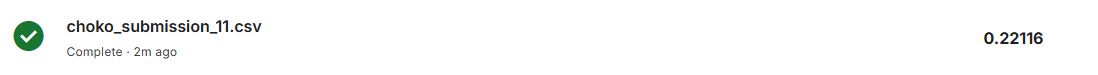